#  Analyse the quality of the PSF for target

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : April 22th  2021
- version v1.0

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from datetime import datetime,date

In [5]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [6]:
string_date

'2021-04-23'

In [7]:
from iminuit import Minuit
import iminuit

In [8]:
iminuit.__version__

'2.2.0'

In [9]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [10]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [11]:
from time import sleep

In [12]:
from astropy.time import Time
import astropy.units as u

# Function

In [13]:
def file_target(filename):
    m=re.findall('^Cor_holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Logbook for file selection

In [14]:
filename_logbook='logbooks/auxtellogbook_2021_v1.2.csv'
filename_logbook_out='logbooks/auxtellogbook_2021_v1.3.csv'

In [15]:
df=pd.read_csv(filename_logbook,index_col=0)

In [16]:
pd.set_option('display.max_rows', None)

In [17]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-02-17T01:45:09.091,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_RG610_HD50896_2021-02-16_181.fits,181,HD50896,RG610,holo4_003,1.006209,90.0,...,10.3,51.0,9.3,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2021-02-17T03:37:12.647,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_empty_HD50896_2021-02-16_209.fits,209,HD50896,empty_1,holo4_003,1.099905,90.0,...,10.4,45.0,9.9,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2021-02-18T07:25:02.387,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_350.fits,350,NGC4755,empty_1,holo4_003,1.158253,6.0,...,8.8,53.0,7.3,750.0,2700.0,NaN,NaN,,1.0,1.0
3,3,2021-02-18T07:25:46.560,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_351.fits,351,NGC4755,empty_1,holo4_003,1.158097,6.0,...,8.8,54.0,6.3,750.0,2700.0,NaN,NaN,,1.0,1.0
4,4,2021-02-18T07:26:07.146,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_352.fits,352,NGC4755,empty_1,holo4_003,1.158027,6.0,...,8.8,54.0,6.3,750.0,2700.0,NaN,NaN,,1.0,1.0
5,5,2021-02-18T07:26:18.957,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_353.fits,353,NGC4755,empty_1,holo4_003,1.157987,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
6,6,2021-02-18T07:26:43.049,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_354.fits,354,NGC4755,empty_1,holo4_003,1.157907,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
7,7,2021-02-18T07:26:51.615,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_355.fits,355,NGC4755,empty_1,holo4_003,1.157879,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
8,8,2021-02-18T07:27:00.190,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_356.fits,356,NGC4755,empty_1,holo4_003,1.157851,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
9,9,2021-02-18T07:27:53.863,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_357.fits,357,NGC4755,empty_1,holo4_003,1.157723,6.0,...,8.7,55.0,6.7,700.0,1700.0,NaN,NaN,,1.0,1.0


# Selection of input file


- the target coordinates 'Obj-posXpix','Obj-posYpix' must exists.

### Drop NA

In [18]:
df.dropna(how='any', subset=['Obj-posXpix','Obj-posYpix'],inplace=True)

## Drop bad quality

In [19]:
i = df[(df.run != 1) | (df.quality != 1)].index

In [20]:
i

Int64Index([12, 13, 25, 42, 44, 45, 46, 47, 48, 49, 55, 56, 57, 58, 59, 60, 61,
            62, 68, 69, 70, 71, 72, 73, 74, 75],
           dtype='int64')

In [21]:
df.drop(i,inplace=True)

In [22]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
2,2,2021-02-18T07:25:02.387,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_350.fits,350,NGC4755,empty_1,holo4_003,1.158253,6.0,...,8.8,53.0,7.3,750.0,2700.0,NaN,NaN,,1.0,1.0
3,3,2021-02-18T07:25:46.560,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_351.fits,351,NGC4755,empty_1,holo4_003,1.158097,6.0,...,8.8,54.0,6.3,750.0,2700.0,NaN,NaN,,1.0,1.0
4,4,2021-02-18T07:26:07.146,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_352.fits,352,NGC4755,empty_1,holo4_003,1.158027,6.0,...,8.8,54.0,6.3,750.0,2700.0,NaN,NaN,,1.0,1.0
5,5,2021-02-18T07:26:18.957,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_353.fits,353,NGC4755,empty_1,holo4_003,1.157987,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
6,6,2021-02-18T07:26:43.049,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_354.fits,354,NGC4755,empty_1,holo4_003,1.157907,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
7,7,2021-02-18T07:26:51.615,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_355.fits,355,NGC4755,empty_1,holo4_003,1.157879,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
8,8,2021-02-18T07:27:00.190,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_356.fits,356,NGC4755,empty_1,holo4_003,1.157851,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
9,9,2021-02-18T07:27:53.863,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_357.fits,357,NGC4755,empty_1,holo4_003,1.157723,6.0,...,8.7,55.0,6.7,700.0,1700.0,NaN,NaN,,1.0,1.0
10,10,2021-02-18T07:29:41.903,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_358.fits,358,NGC4755,empty_1,holo4_003,1.157296,6.0,...,8.7,56.0,6.8,500.0,1800.0,NaN,NaN,,1.0,1.0
11,11,2021-02-19T05:53:27.926,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits,556,HD60753,RG610,holo4_003,1.392359,5.0,...,9.9,41.0,8.2,300.0,2500.0,NaN,NaN,,1.0,1.0


In [23]:
dir_images="/Users/dagoret/DATA/AuxTelData2021/holo/FlipCleans"
disperser_label = "holo4_003"
config = "config/auxtel_quicklook.ini"

In [24]:
idx=0
for filename_image in df["file"]:
    
    fullfilename=os.path.join(dir_images,filename_image)
    X=df.iloc[idx]["Obj-posXpix"]
    Y=df.iloc[idx]["Obj-posYpix"]
    guess = [X,Y]
    target = file_target(filename_image)[0]
    print(filename_image," ",target," ",guess)
    idx+=1

Cor_holo4_003_NGC4755_2021-02-17_350.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_351.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_352.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_353.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_354.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_355.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_356.fits   NGC4755   [750.0, 2700.0]
Cor_holo4_003_NGC4755_2021-02-17_357.fits   NGC4755   [700.0, 1700.0]
Cor_holo4_003_NGC4755_2021-02-17_358.fits   NGC4755   [500.0, 1800.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits   HD60753   [300.0, 2500.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits   HD60753   [1800.0, 2500.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits   HD60753   [400.0, 2500.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits   HD60753   [400.0, 2500.0]
Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits   HD60753   [400.

# Configuration of the running mode

In [25]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [26]:
FLAG_SHOW_SPECTRACTOR_IMAGES = False

In [27]:
if FLAG_SHOW_SPECTRACTOR_IMAGES:

    idx=0
    for filename_image in df["file"]:
    
        fullfilename=os.path.join(dir_images,filename_image)
        X=df.iloc[idx]["Obj-posXpix"]
        Y=df.iloc[idx]["Obj-posYpix"]
        guess = [int(X),int(Y)]
        target = file_target(filename_image)[0]
        print(idx,")  ",filename_image," ",target," ",guess)
    

        image=Image(file_name=fullfilename, target_label=target, disperser_label=disperser_label, config=config)
        image.plot_image(figsize=(12, 10),scale="log")
        idx+=1

0) Cor_holo4_003_NGC4755_2021-02-17_350.fits NGC4755


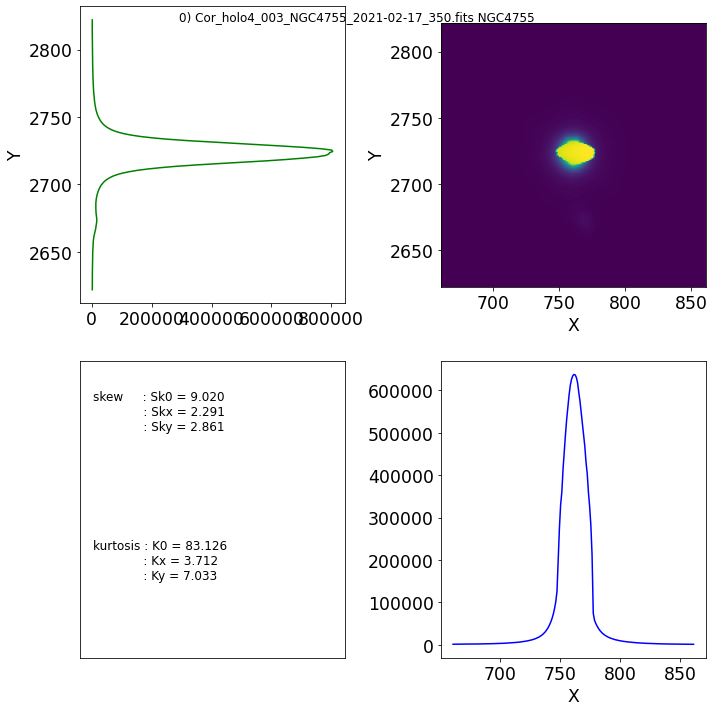

1) Cor_holo4_003_NGC4755_2021-02-17_351.fits NGC4755


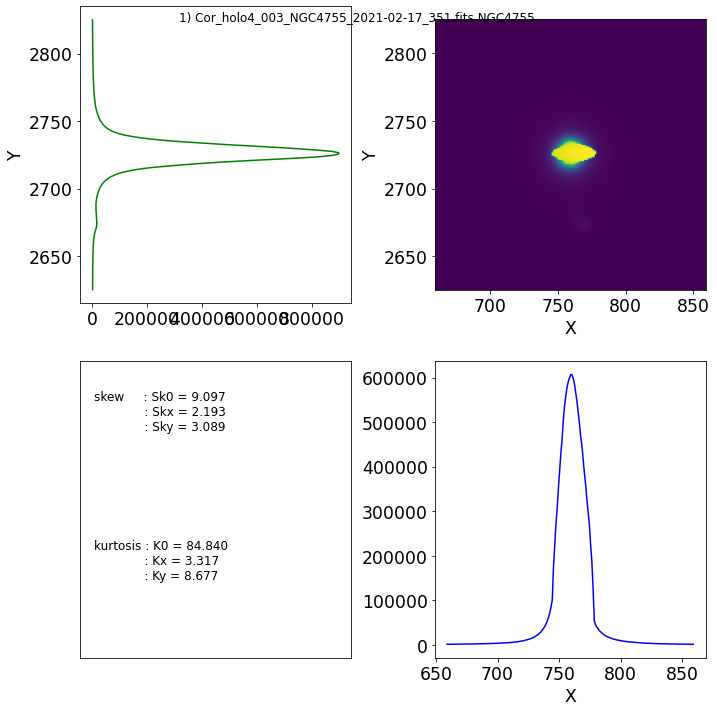

2) Cor_holo4_003_NGC4755_2021-02-17_352.fits NGC4755


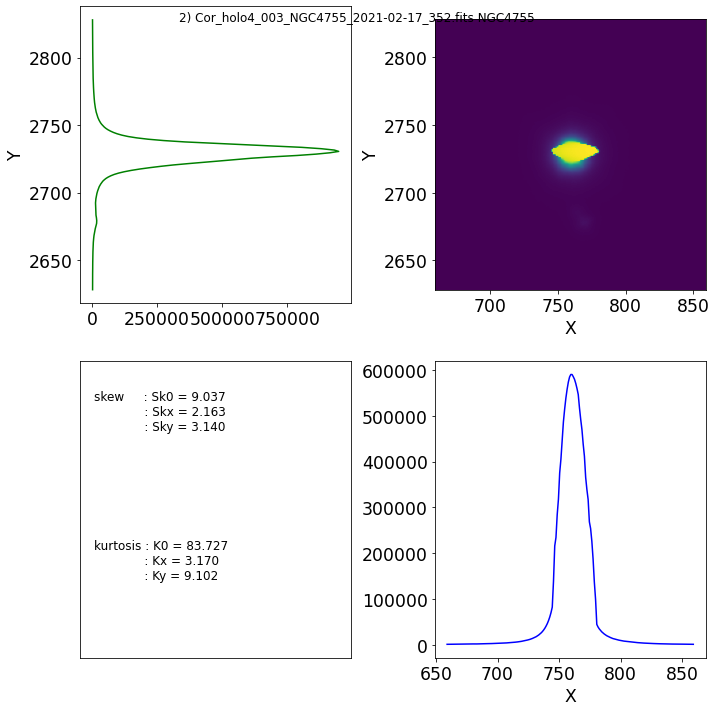

3) Cor_holo4_003_NGC4755_2021-02-17_353.fits NGC4755


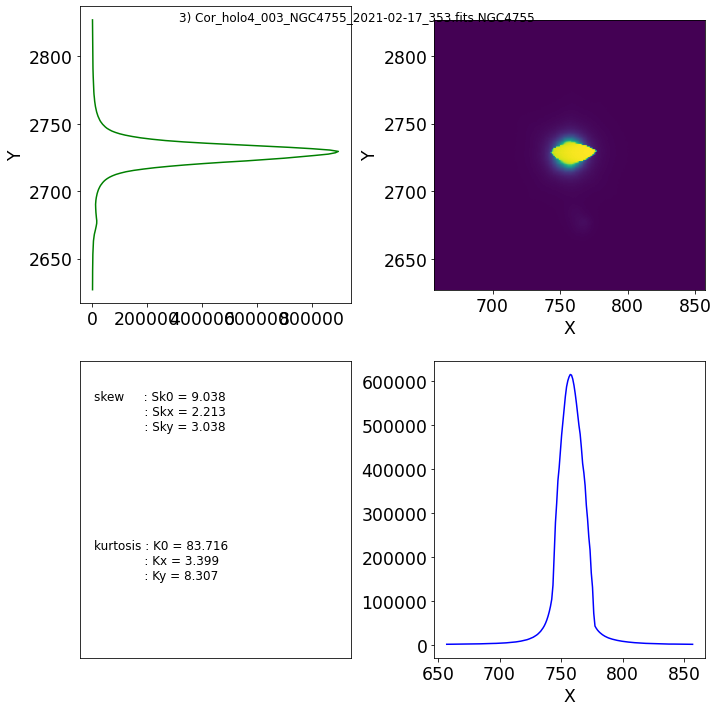

4) Cor_holo4_003_NGC4755_2021-02-17_354.fits NGC4755


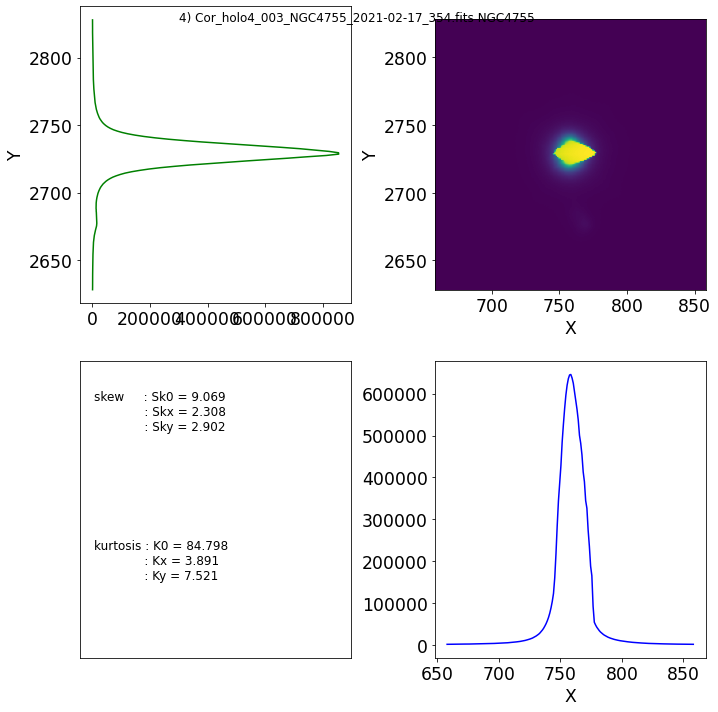

5) Cor_holo4_003_NGC4755_2021-02-17_355.fits NGC4755


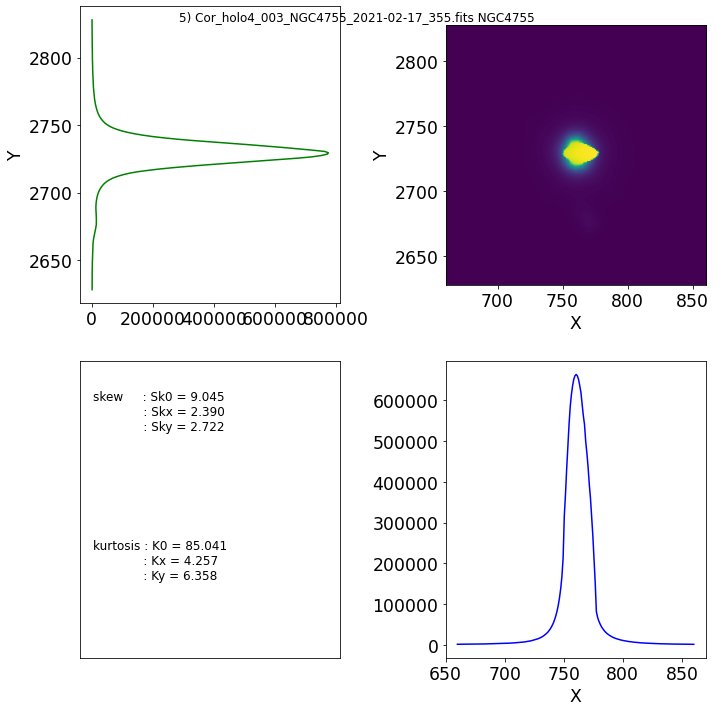

6) Cor_holo4_003_NGC4755_2021-02-17_356.fits NGC4755


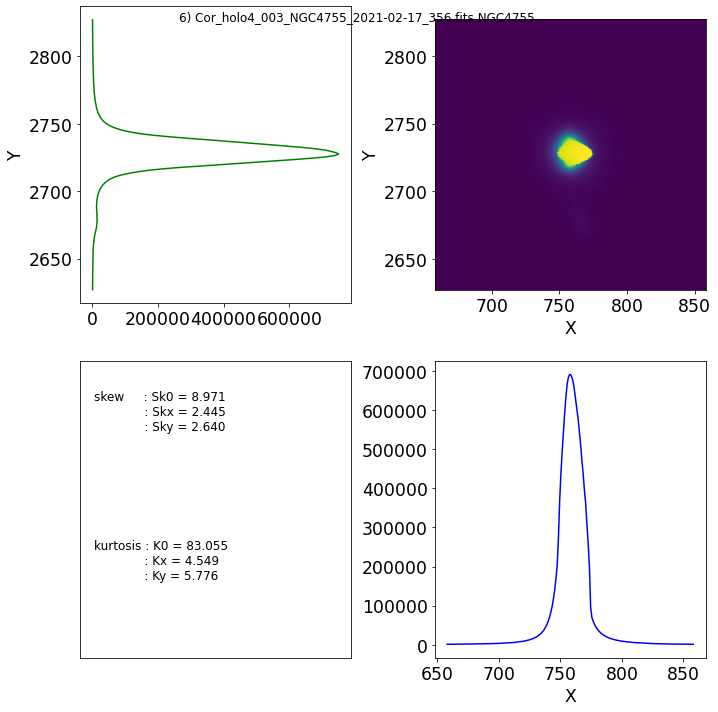

7) Cor_holo4_003_NGC4755_2021-02-17_357.fits NGC4755


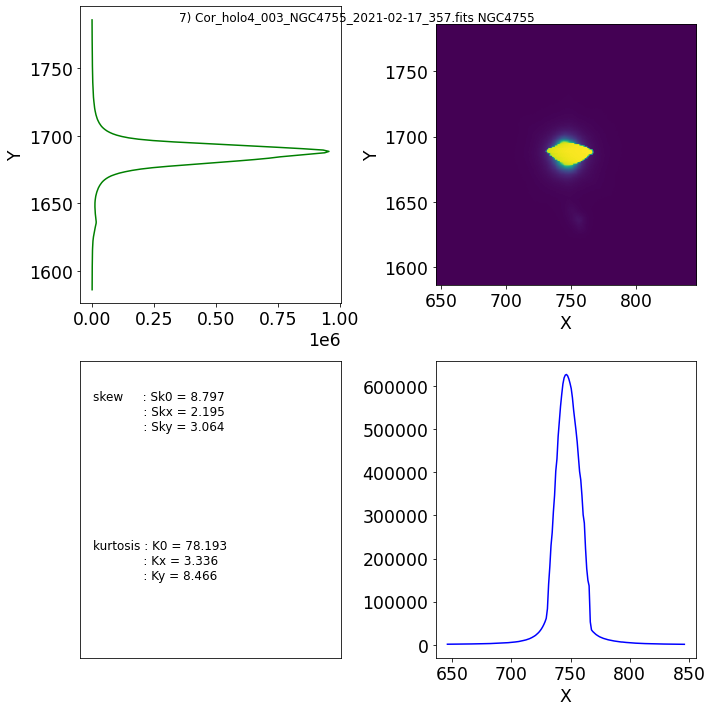

8) Cor_holo4_003_NGC4755_2021-02-17_358.fits NGC4755


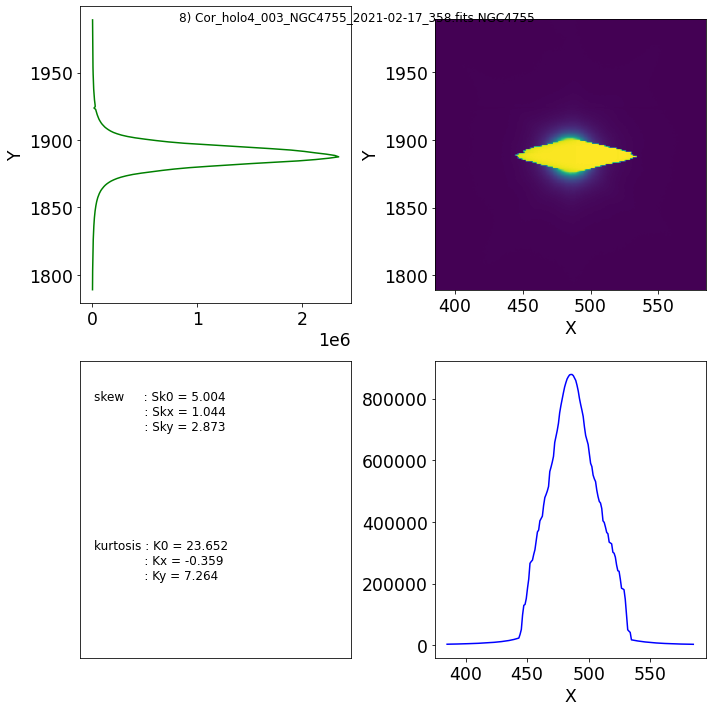

9) Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits HD60753


2021-04-23 11:30:28  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.358038467488372 but average of self.read_out_noise is 8.5.


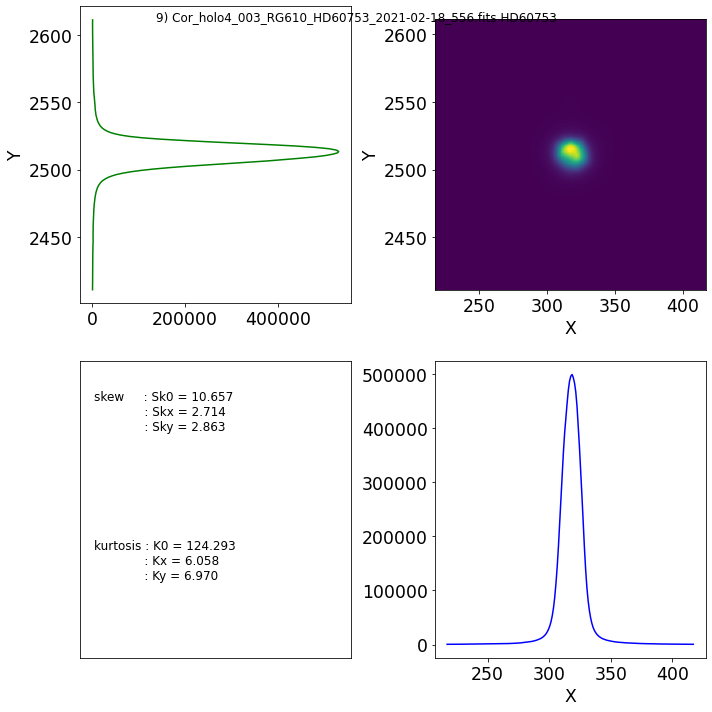

10) Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits HD60753


2021-04-23 11:30:39  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.358019790912053 but average of self.read_out_noise is 8.5.


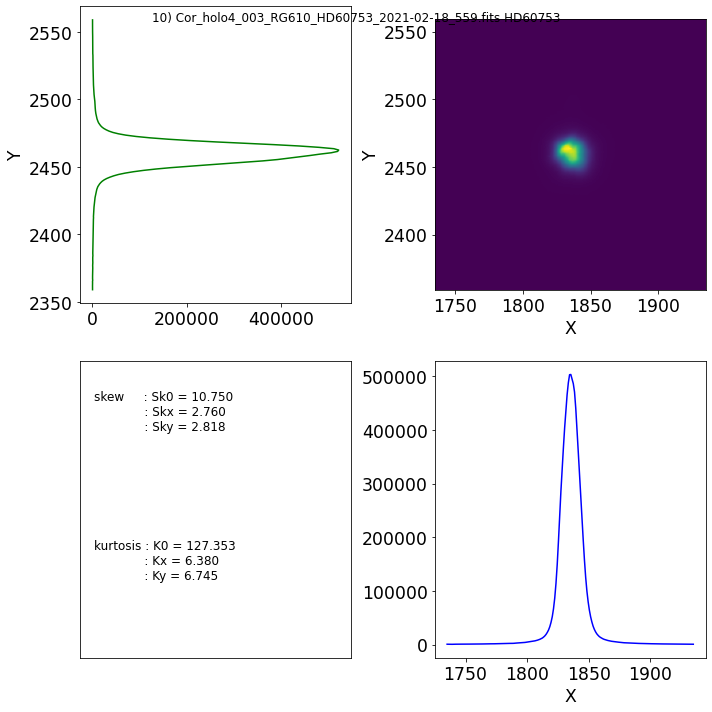

11) Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits HD60753


2021-04-23 11:30:49  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.354501572925415 but average of self.read_out_noise is 8.5.


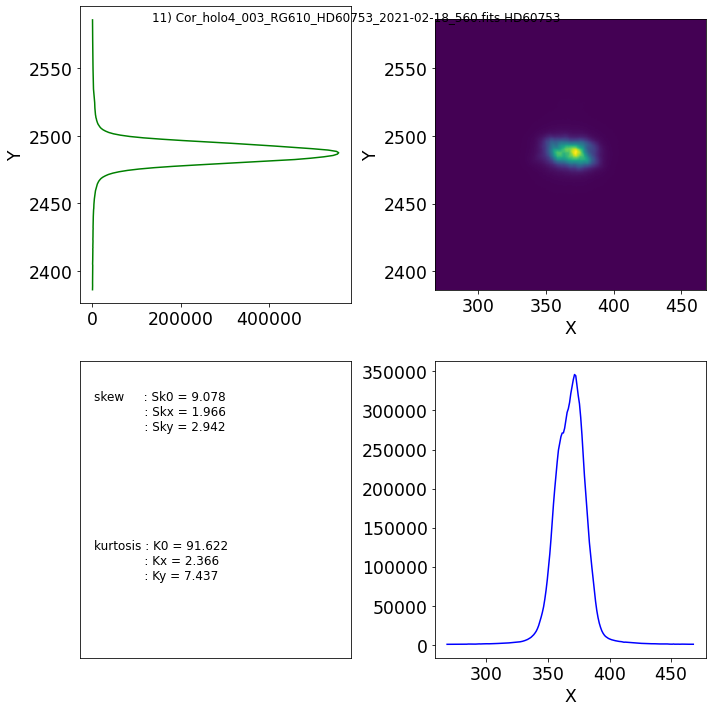

12) Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits HD60753


2021-04-23 11:30:59  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.404876204890407 but average of self.read_out_noise is 8.5.


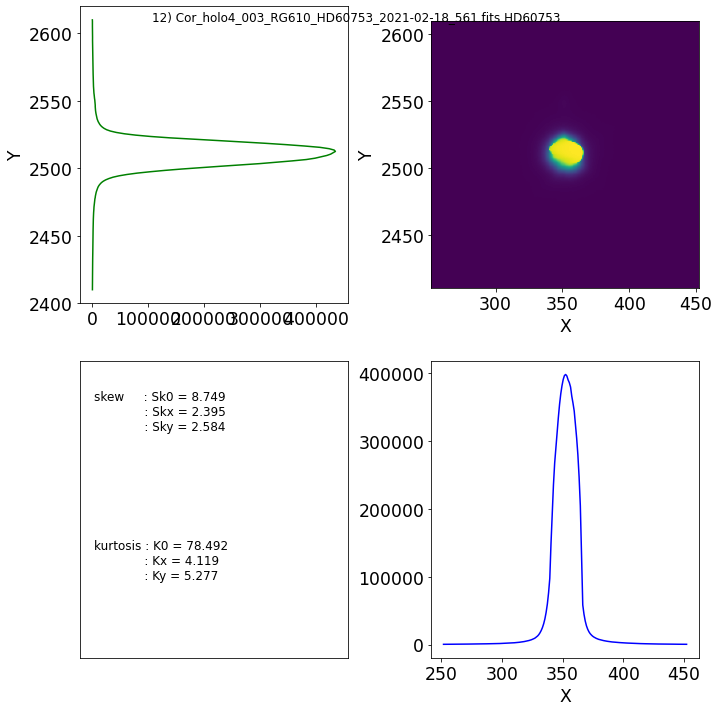

13) Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits HD60753


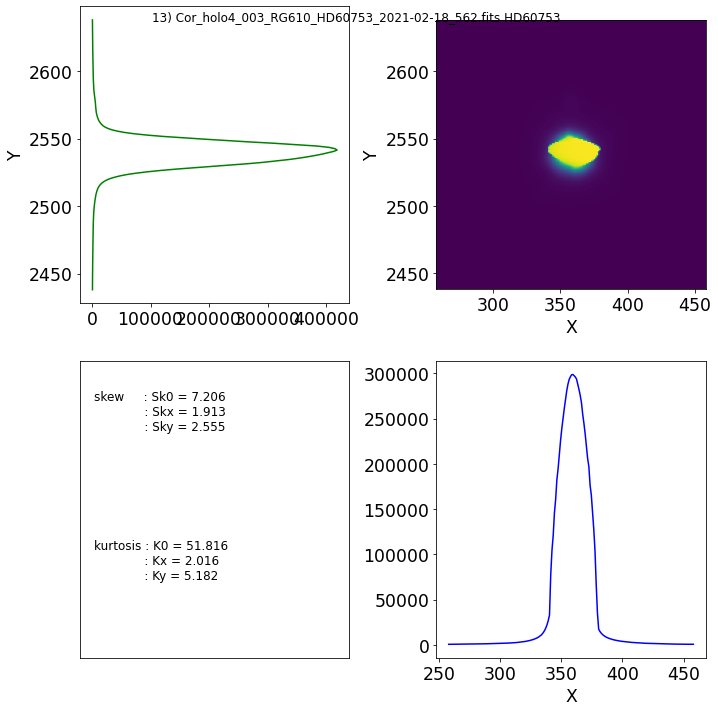

14) Cor_holo4_003_RG610_HD60753_2021-02-18_563.fits HD60753


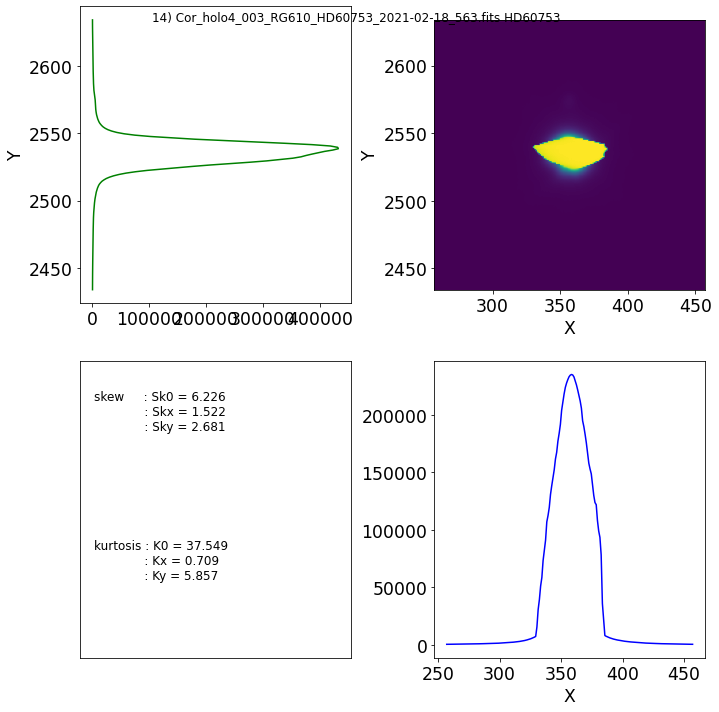

15) Cor_holo4_003_RG610_HD60753_2021-02-18_564.fits HD60753


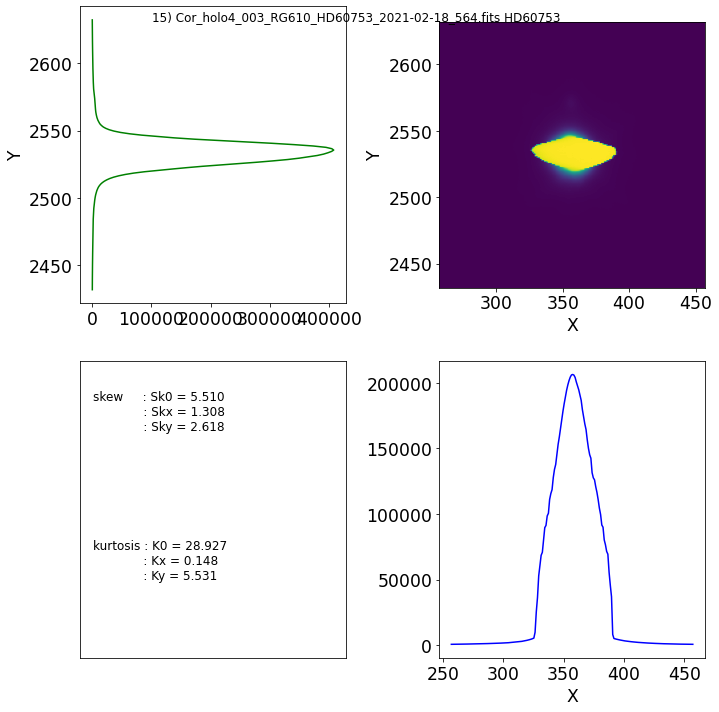

16) Cor_holo4_003_empty_HD60753_2021-02-18_566.fits HD60753


2021-04-23 11:31:48  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.382535473682855 but average of self.read_out_noise is 8.5.


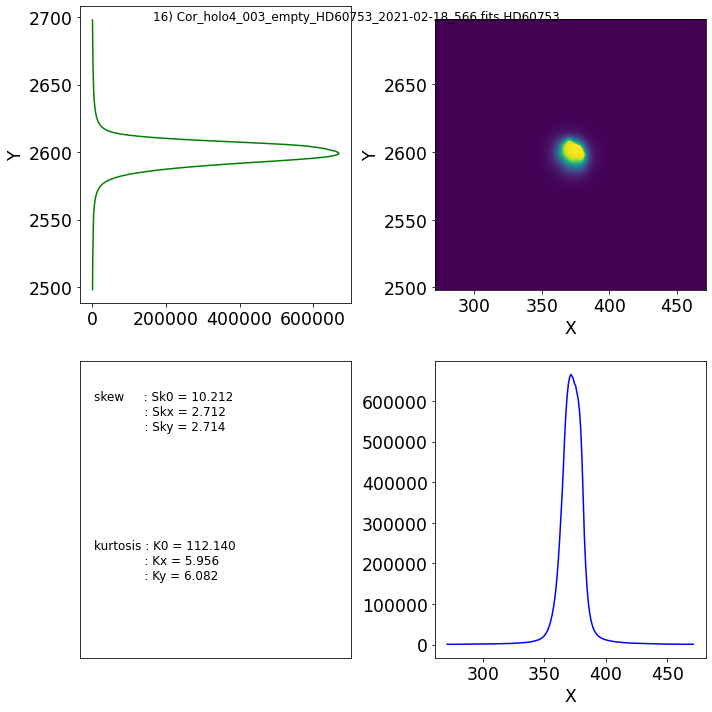

17) Cor_holo4_003_empty_HD60753_2021-02-18_567.fits HD60753


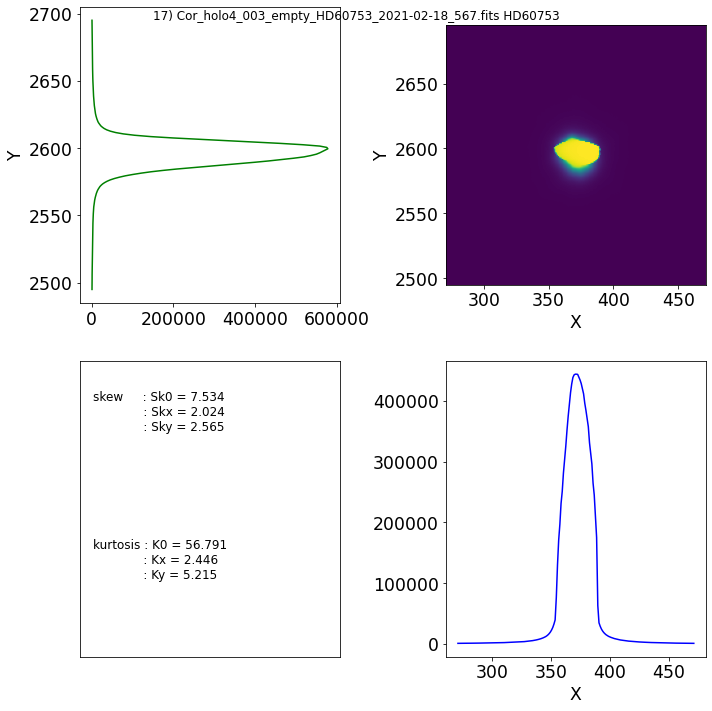

18) Cor_holo4_003_empty_HD60753_2021-02-18_568.fits HD60753


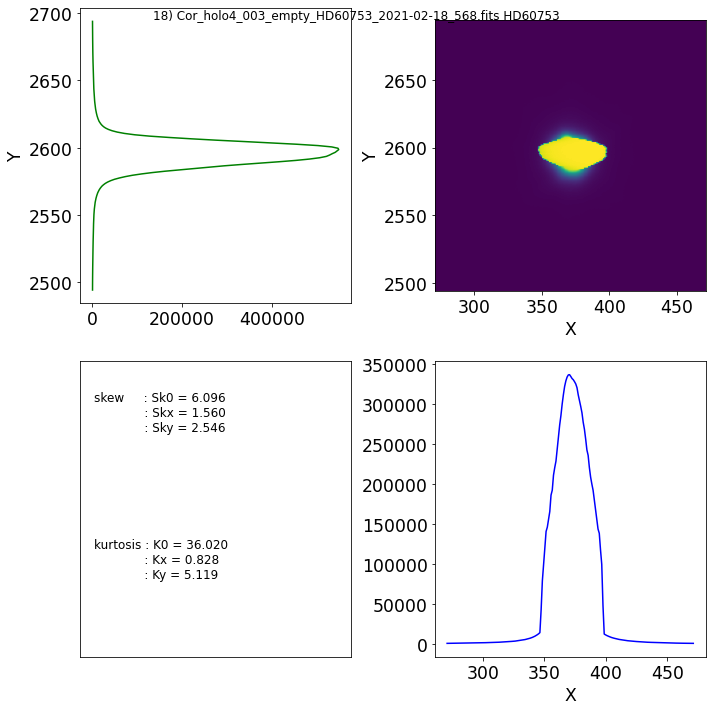

19) Cor_holo4_003_empty_HD60753_2021-02-18_569.fits HD60753


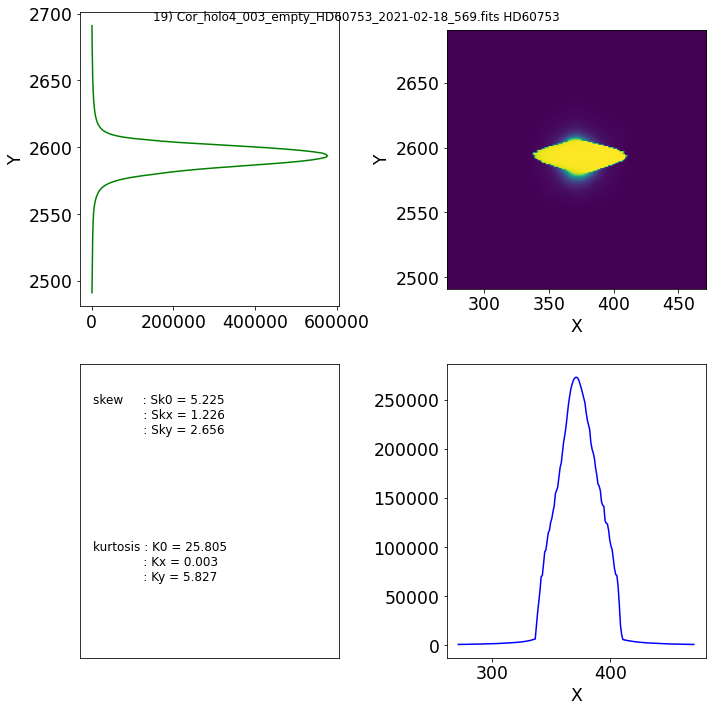

20) Cor_holo4_003_empty_HD60753_2021-02-18_570.fits HD60753


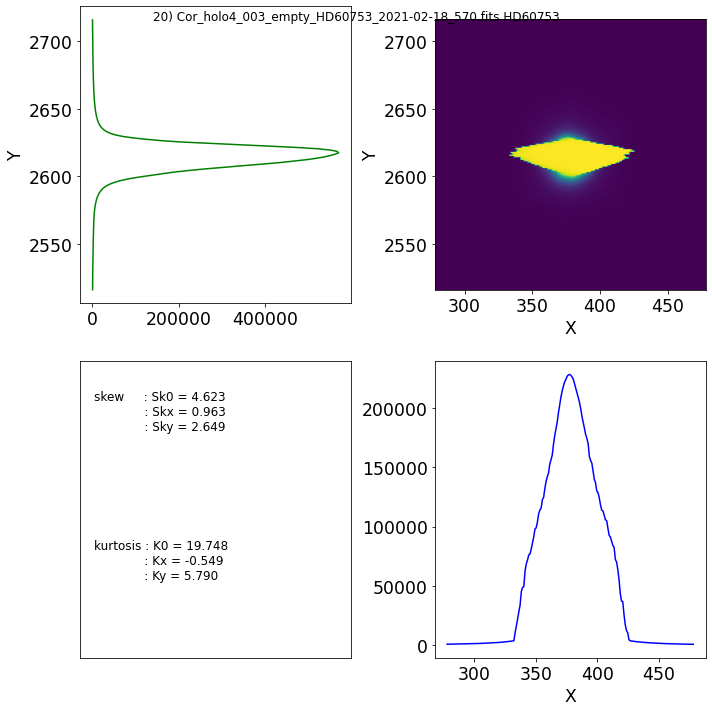

21) Cor_holo4_003_empty_HD60753_2021-02-18_572.fits HD60753


2021-04-23 11:32:49  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.385541622870022 but average of self.read_out_noise is 8.5.


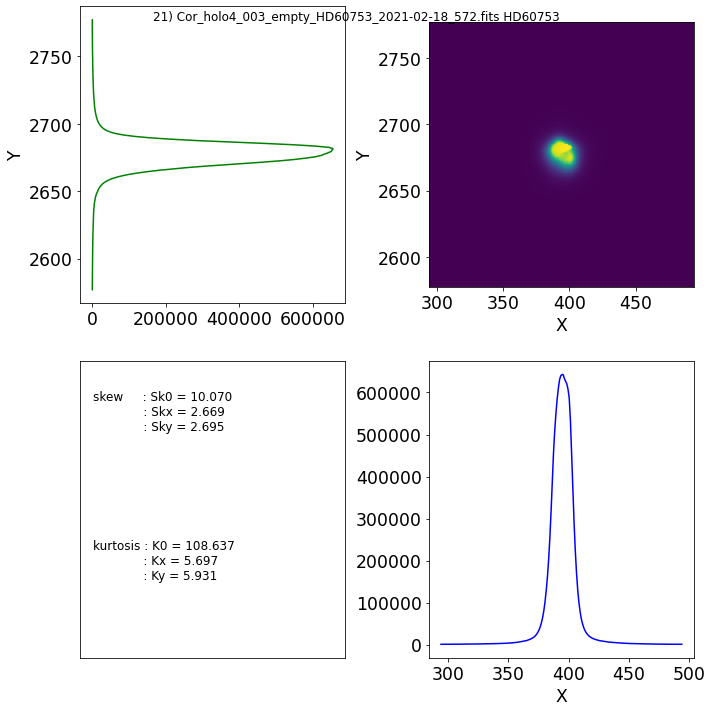

22) Cor_holo4_003_empty_HD60753_2021-02-18_573.fits HD60753


2021-04-23 11:32:58  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.328332203183342 but average of self.read_out_noise is 8.5.


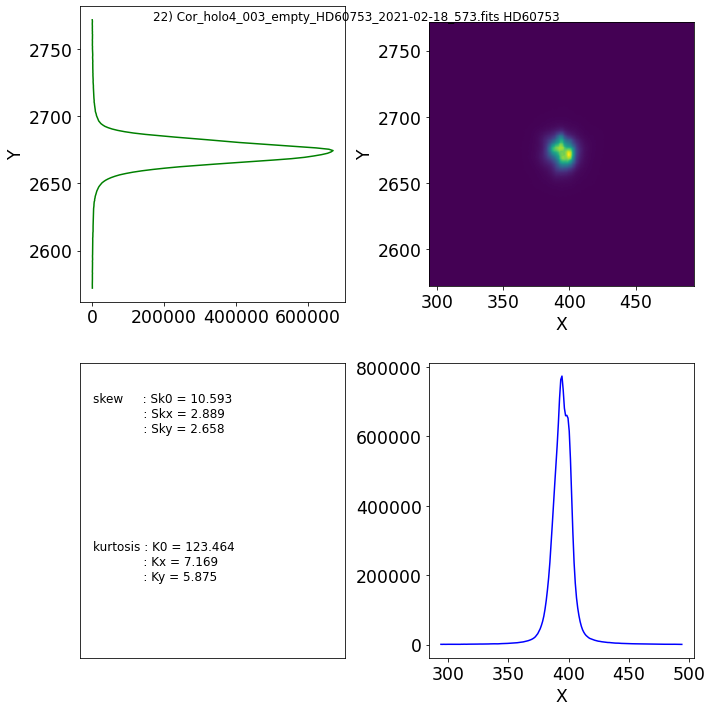

23) Cor_holo4_003_empty_HD60753_2021-02-18_574.fits HD60753


2021-04-23 11:33:10  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.314410398246853 but average of self.read_out_noise is 8.5.


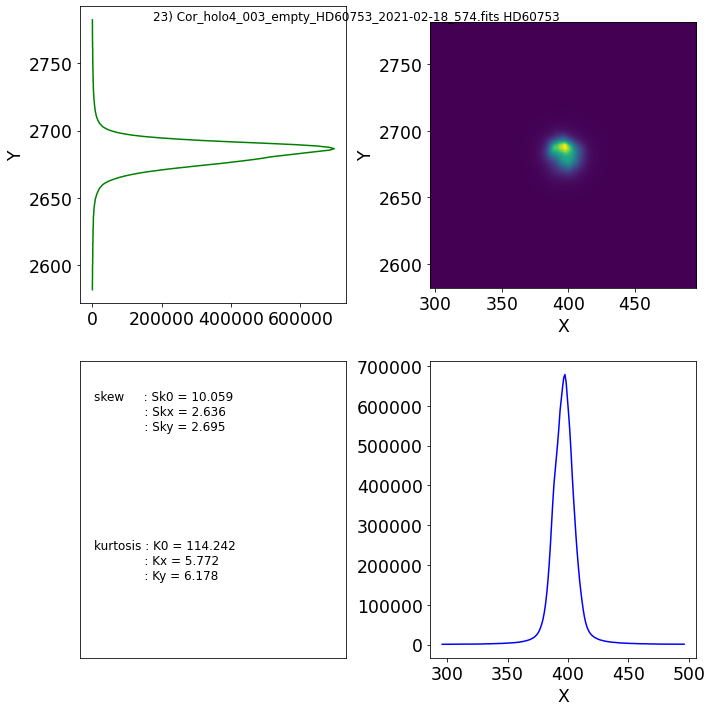

24) Cor_holo4_003_empty_HD60753_2021-02-18_575.fits HD60753


2021-04-23 11:33:21  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.304168216053602 but average of self.read_out_noise is 8.5.


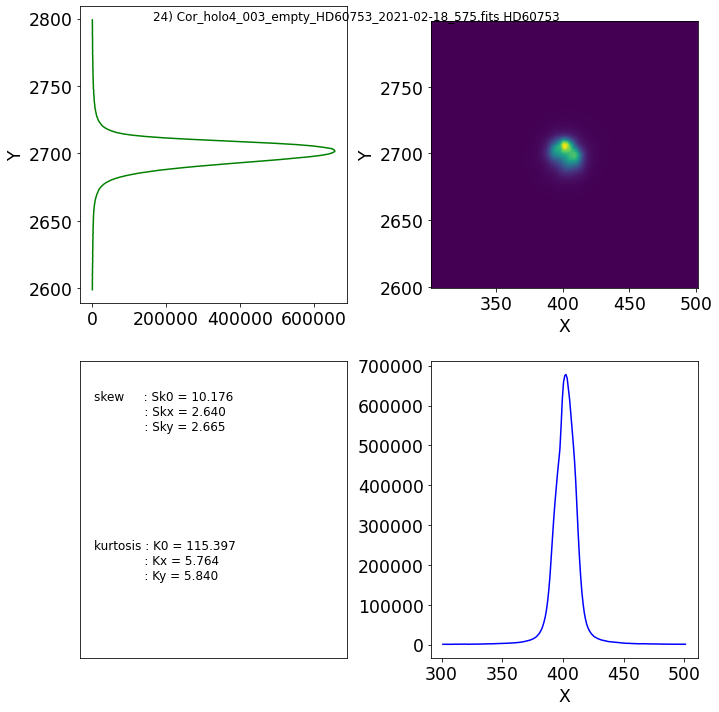

25) Cor_holo4_003_empty_HD60753_2021-02-18_576.fits HD60753


2021-04-23 11:33:32  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.314063223847134 but average of self.read_out_noise is 8.5.


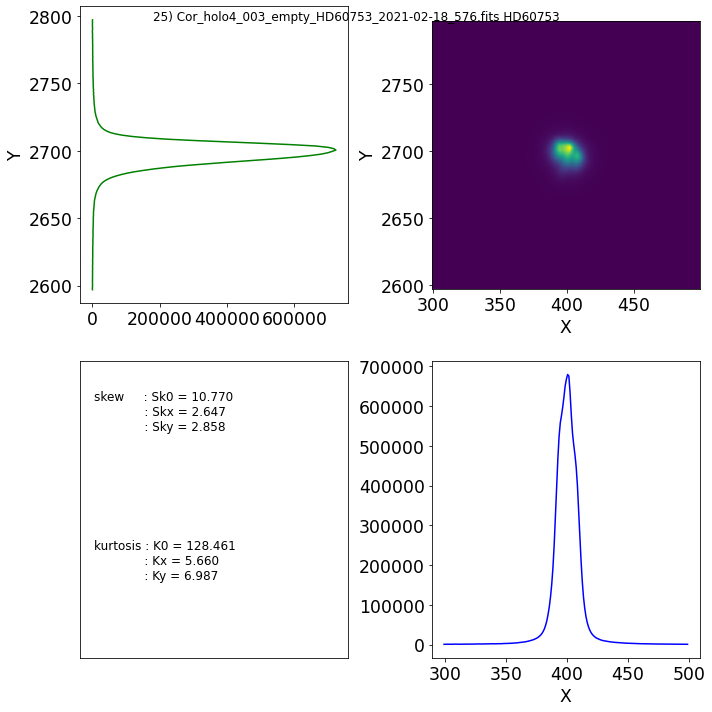

26) Cor_holo4_003_empty_HD60753_2021-02-18_577.fits HD60753


2021-04-23 11:33:42  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.324224133709798 but average of self.read_out_noise is 8.5.


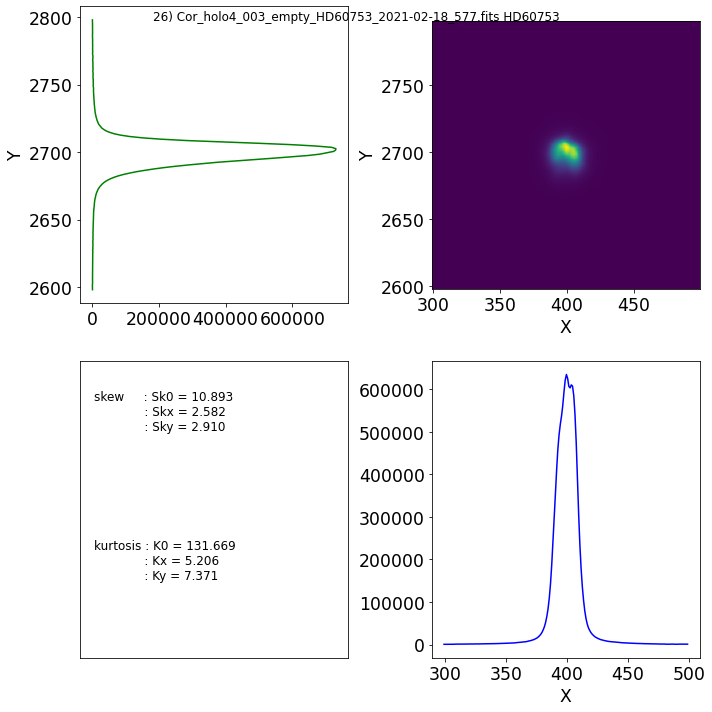

27) Cor_holo4_003_empty_HD60753_2021-02-18_578.fits HD60753


2021-04-23 11:33:53  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.3127832333814 but average of self.read_out_noise is 8.5.


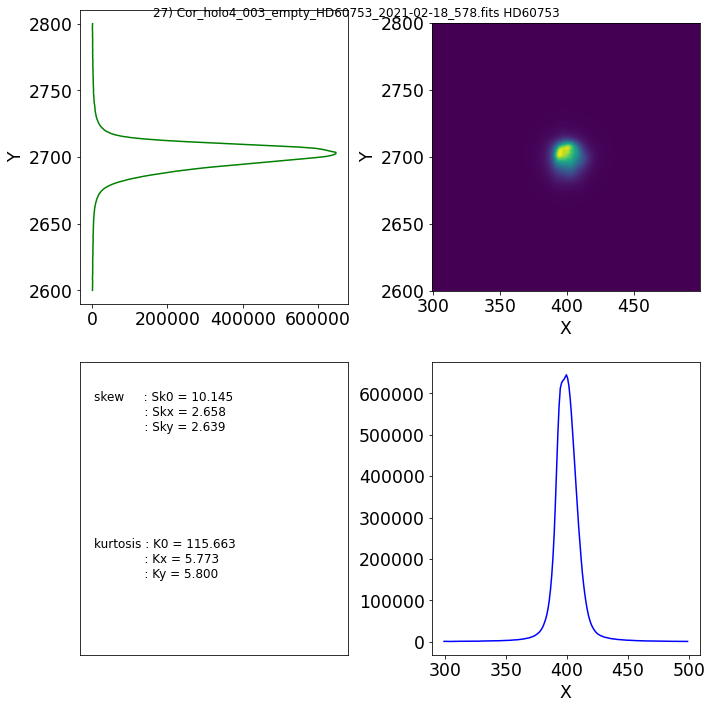

28) Cor_holo4_003_empty_HD60753_2021-02-18_579.fits HD60753


2021-04-23 11:34:04  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.318389824134375 but average of self.read_out_noise is 8.5.


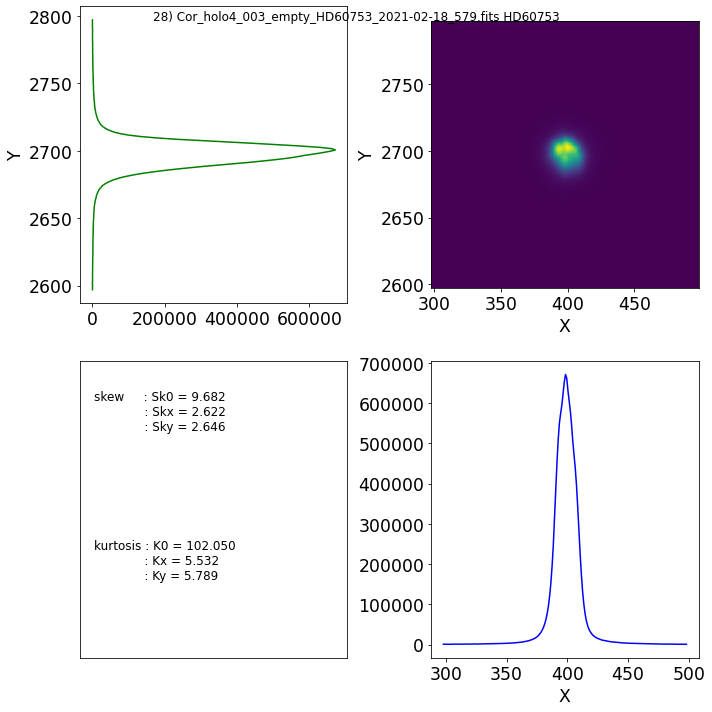

29) Cor_holo4_003_empty_HD60753_2021-02-18_580.fits HD60753


2021-04-23 11:34:16  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.318192815971935 but average of self.read_out_noise is 8.5.


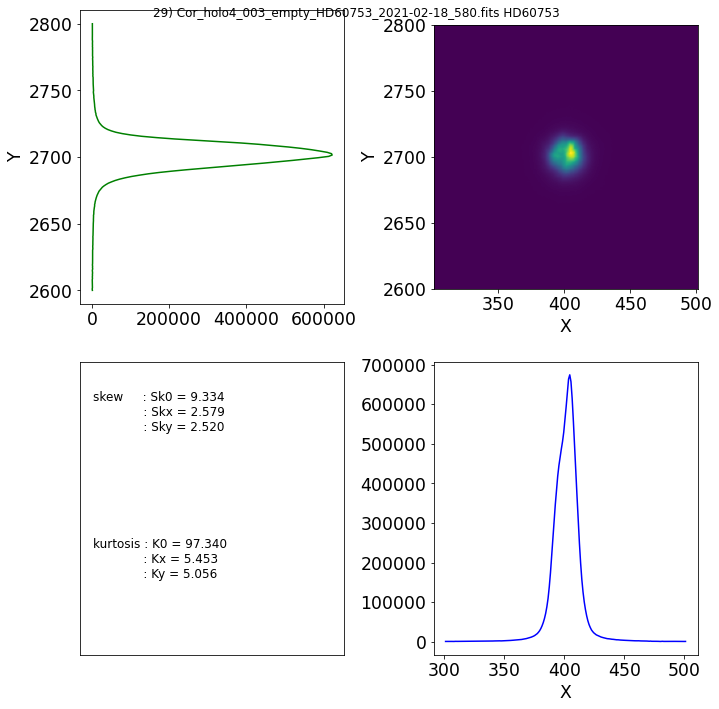

30) Cor_holo4_003_empty_HD60753_2021-02-18_581.fits HD60753


2021-04-23 11:34:26  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.316524643496024 but average of self.read_out_noise is 8.5.


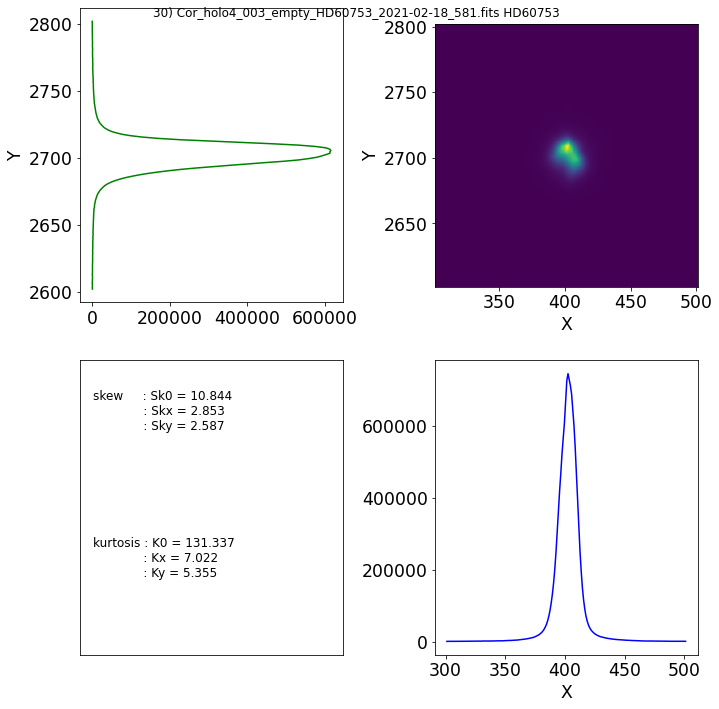

31) Cor_holo4_003_empty_HD60753_2021-02-18_582.fits HD60753


2021-04-23 11:34:36  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.315372257450537 but average of self.read_out_noise is 8.5.


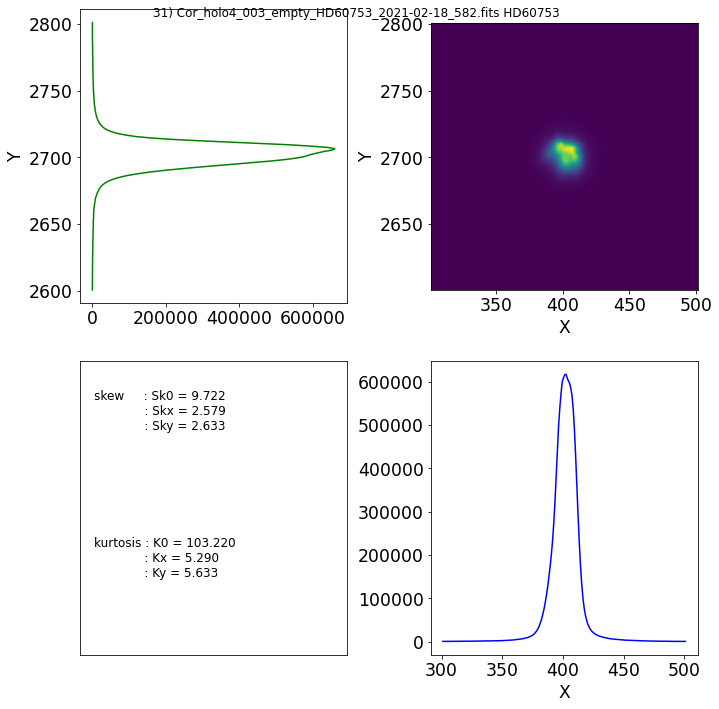

32) Cor_holo4_003_empty_HD60753_2021-02-18_583.fits HD60753


2021-04-23 11:34:48  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.389962490381906 but average of self.read_out_noise is 8.5.


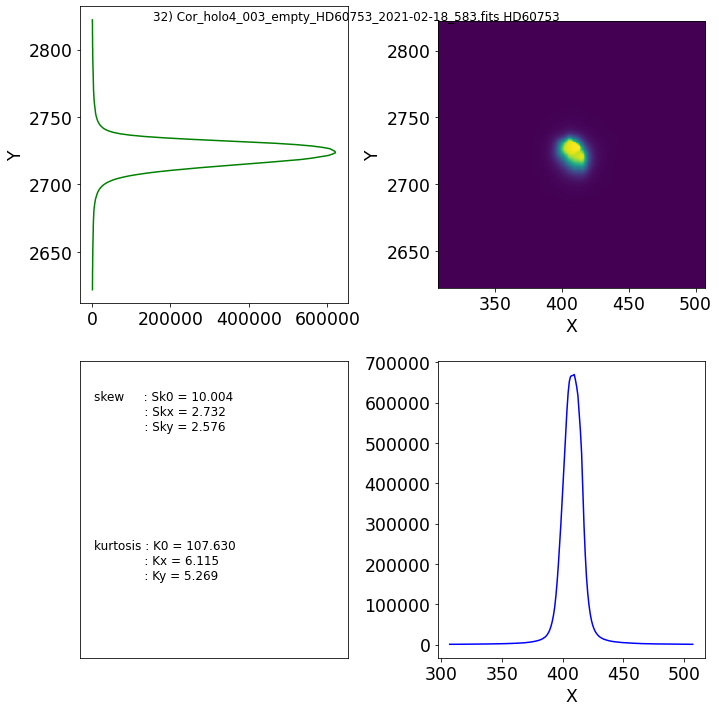

33) Cor_holo4_003_empty_HD60753_2021-02-18_584.fits HD60753


2021-04-23 11:35:02  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.391464012880427 but average of self.read_out_noise is 8.5.


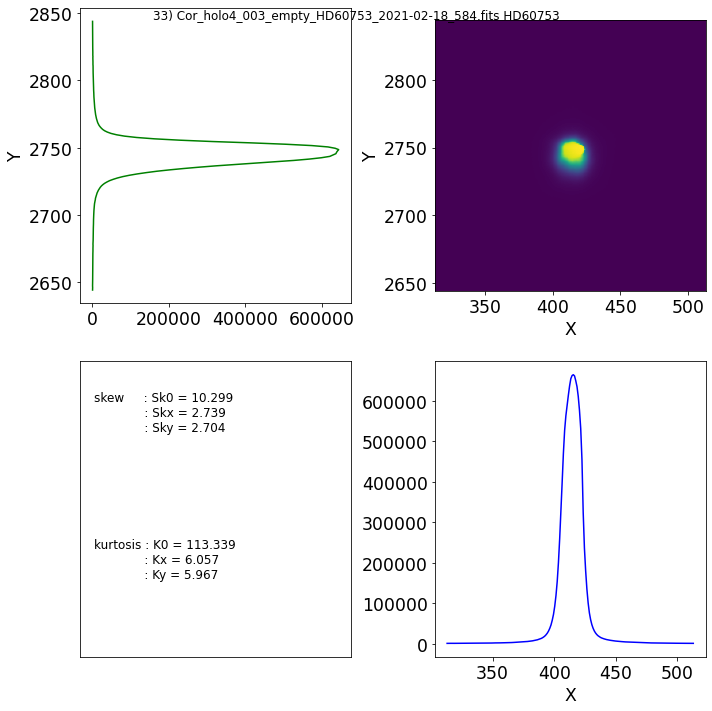

34) Cor_holo4_003_empty_HD60753_2021-02-18_585.fits HD60753


2021-04-23 11:35:13  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.38898809440338 but average of self.read_out_noise is 8.5.


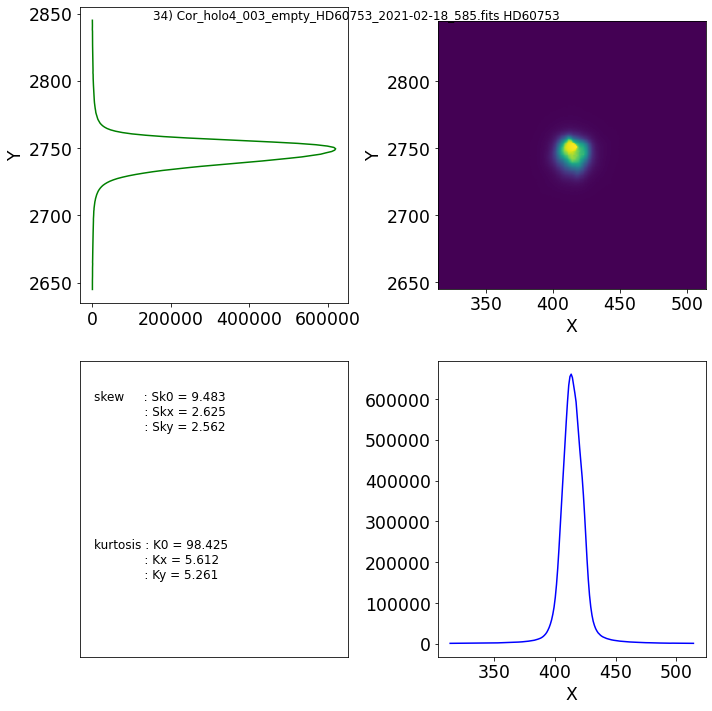

35) Cor_holo4_003_empty_HD60753_2021-02-18_586.fits HD60753


2021-04-23 11:35:25  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.383683020316141 but average of self.read_out_noise is 8.5.


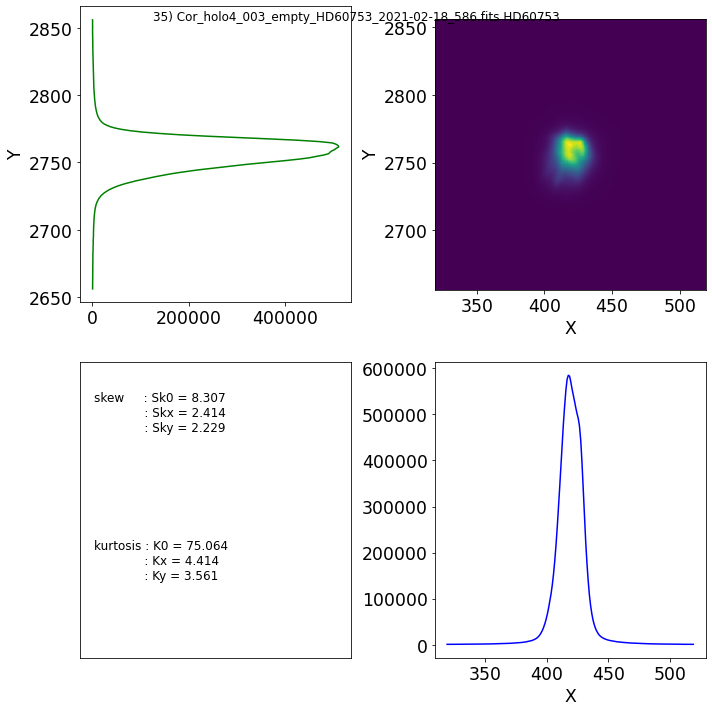

36) Cor_holo4_003_empty_HD60753_2021-02-18_587.fits HD60753


2021-04-23 11:35:37  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.383877583596774 but average of self.read_out_noise is 8.5.


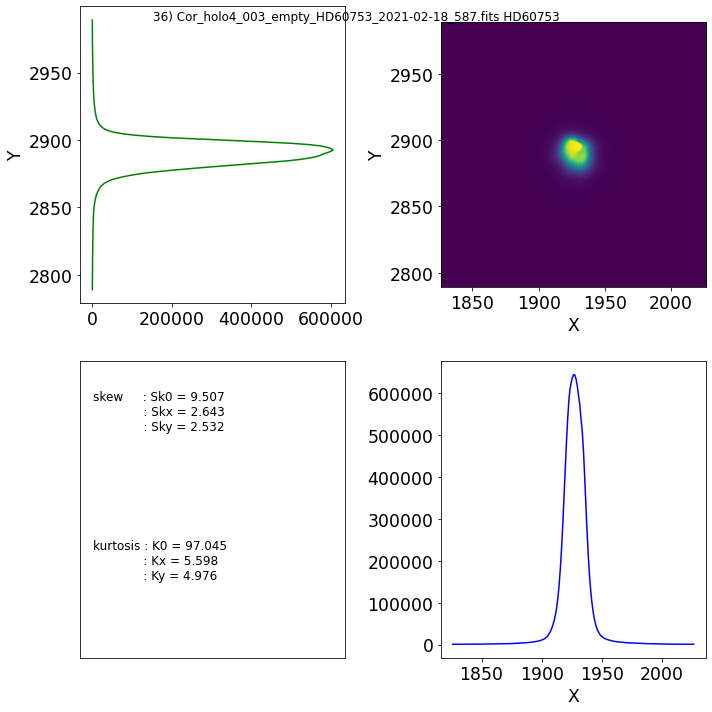

37) Cor_holo4_003_RG610_HD75519_2021-03-11_191.fits HD75519


2021-04-23 11:35:48  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.408695615217948 but average of self.read_out_noise is 8.5.


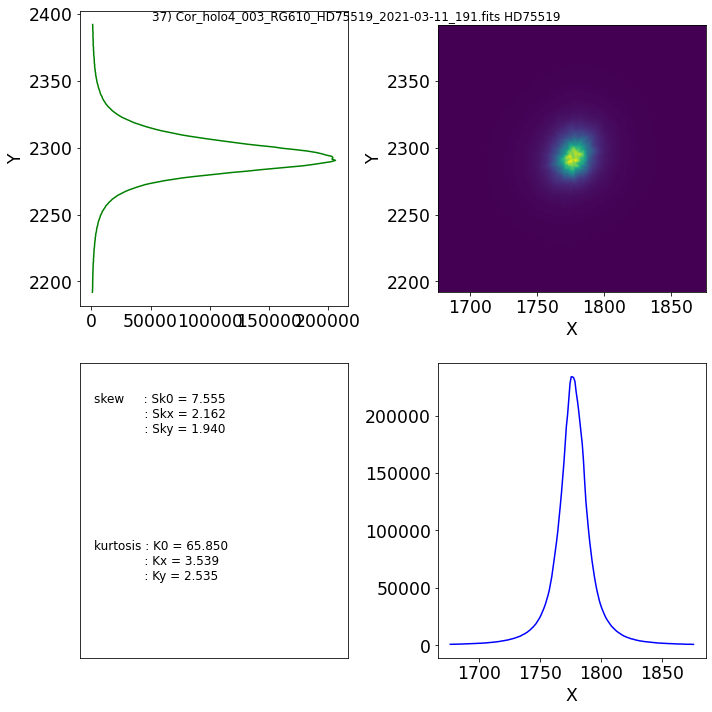

38) Cor_holo4_003_RG610_HD75519_2021-03-11_192.fits HD75519


2021-04-23 11:35:58  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.407901568205844 but average of self.read_out_noise is 8.5.


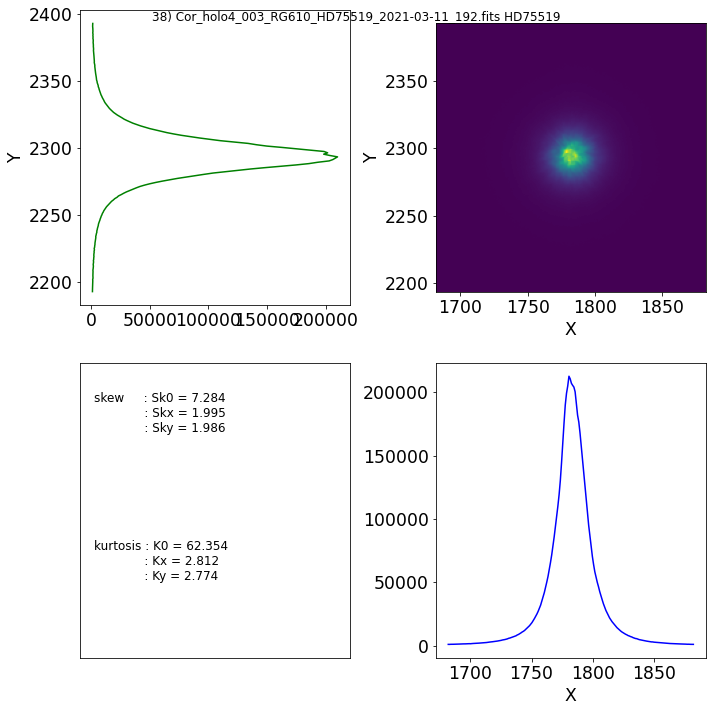

39) Cor_holo4_003_RG610_HD75519_2021-03-11_193.fits HD75519


2021-04-23 11:36:09  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.405934420449931 but average of self.read_out_noise is 8.5.


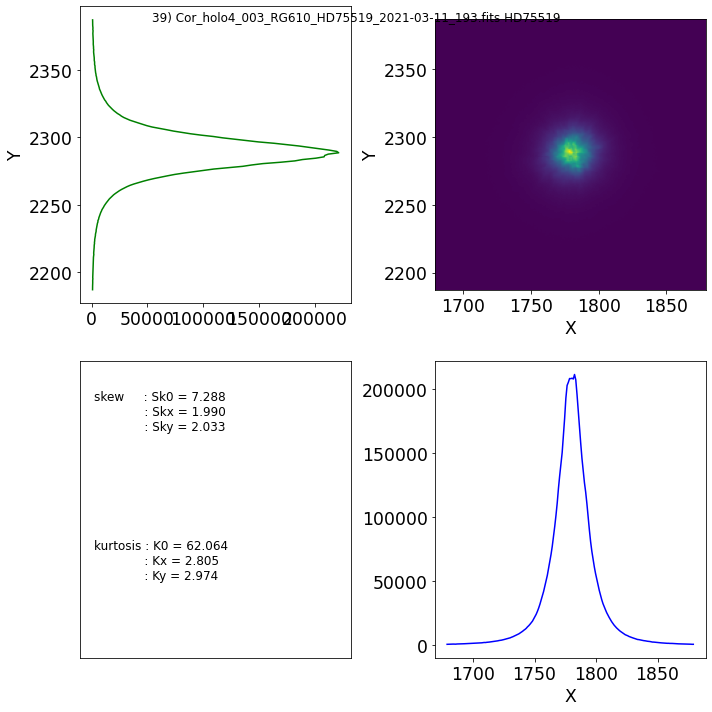

40) Cor_holo4_003_RG610_HD75519_2021-03-11_292.fits HD75519


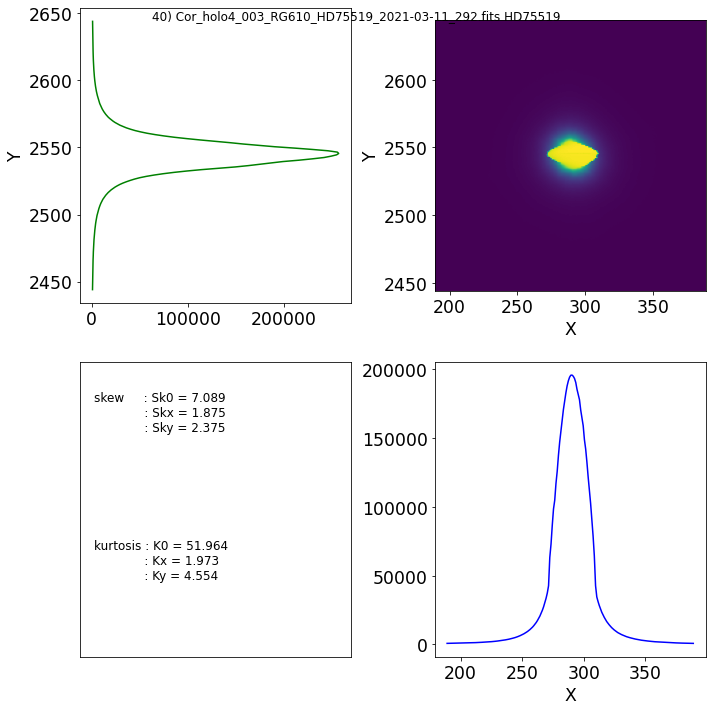

41) Cor_holo4_003_RG610_HD75519_2021-03-11_293.fits HD75519


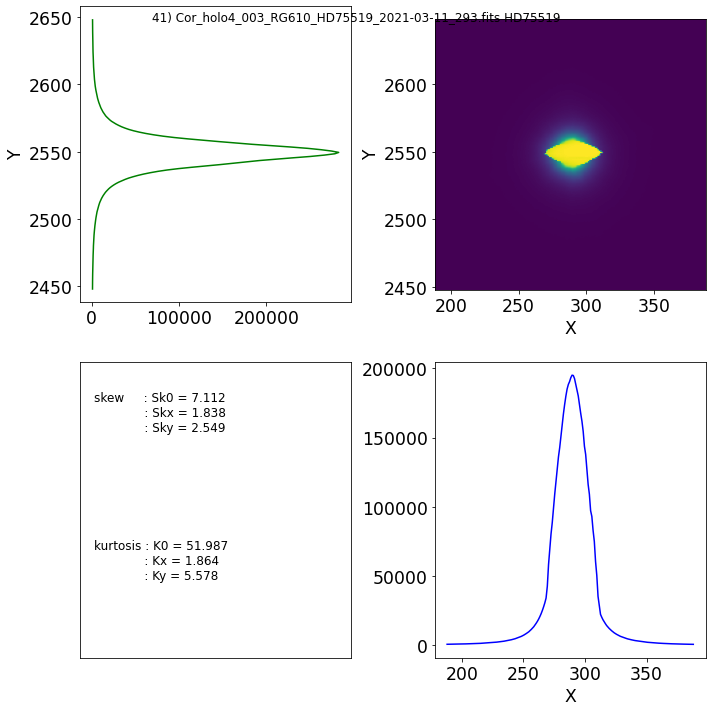

42) Cor_holo4_003_RG610_HD75519_2021-03-11_294.fits HD75519


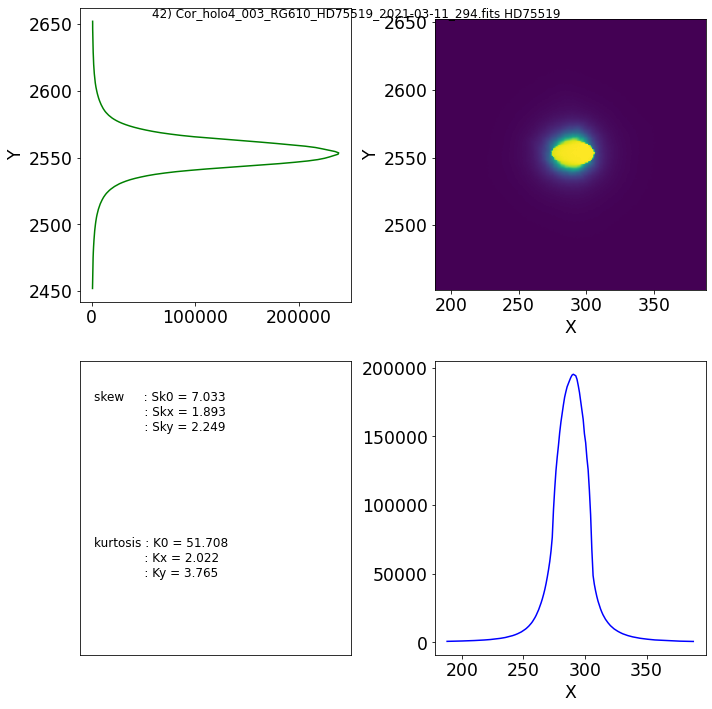

43) Cor_holo4_003_RG610_HD75519_2021-03-11_295.fits HD75519


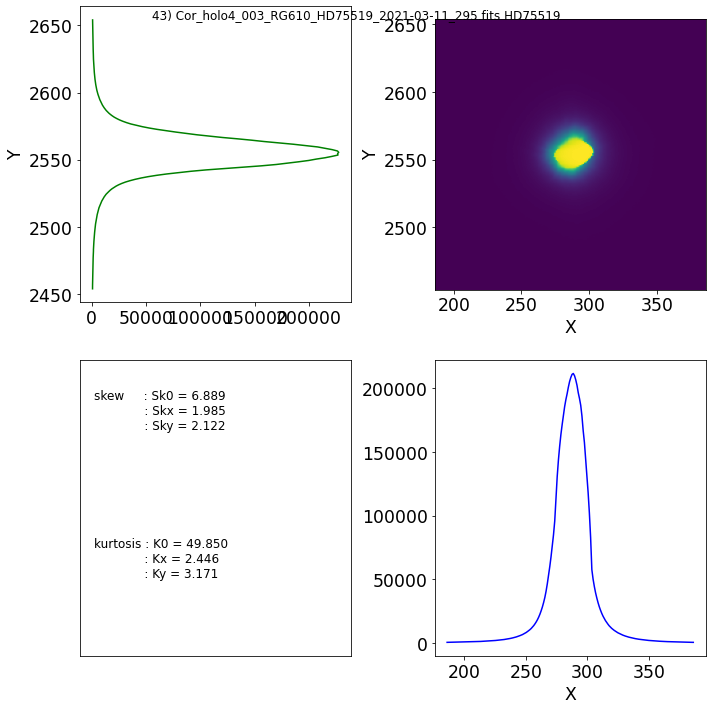

44) Cor_holo4_003_RG610_HD75519_2021-03-11_296.fits HD75519


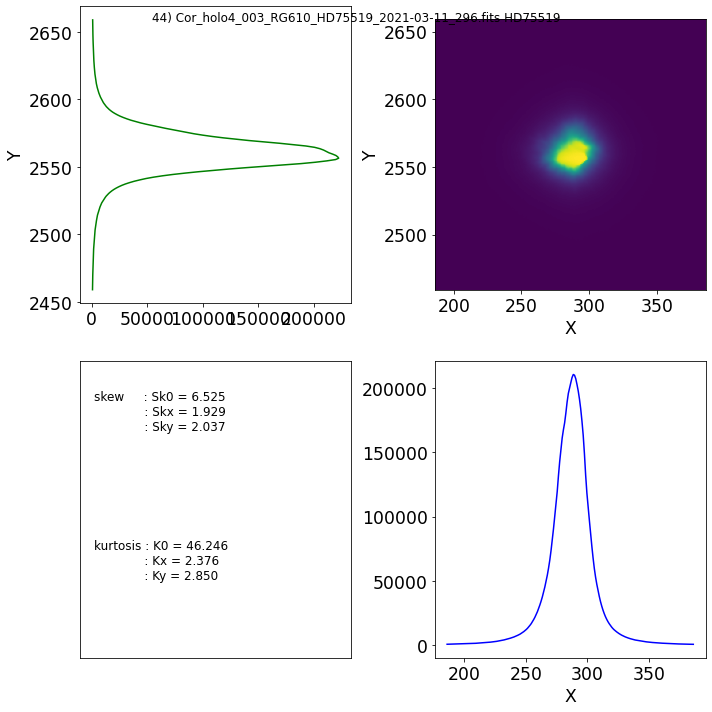

In [28]:
idx=0
for filename_image in df["file"]:
    
    
    try:
    
        fullfilename=os.path.join(dir_images,filename_image)
        X=df.iloc[idx]["Obj-posXpix"]
        Y=df.iloc[idx]["Obj-posYpix"]
        guess = [int(X),int(Y)]
        target = file_target(filename_image)[0]
    
        title=str(idx) + ") "+ filename_image + " " + target 
        print(title)
    

        image=Image(file_name=fullfilename, target_label=target, disperser_label=disperser_label, config=config)
        #image.plot_image(figsize=(12, 10),scale="log")
        parameters.VERBOSE = False
        parameters.DEBUG = False
        x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
    
        if x1>100:
            WID=100
        else:
            WID=50
    

        thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
        thumbnail_y=thumbnail.sum(axis=1)
        thumbnail_x=thumbnail.sum(axis=0)
        xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
        yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
        k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
        kx=kurtosis(thumbnail_x,bias=True,fisher=True)
        ky=kurtosis(thumbnail_y,bias=True,fisher=True)
        s0=skew(thumbnail,axis=None,bias=True)
        sx=skew(thumbnail_x,bias=True)
        sy=skew(thumbnail_y,bias=True)
        
    
        shape_str='\n'.join((
            r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
            r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))
    
        skew_str='\n'.join((
            r'skew     : Sk0 = {:3.3f}'.format(s0),
            r'             : Skx = {:3.3f}'.format(sx),
            r'             : Sky = {:3.3f}'.format(sy)))
    
    
        kurt_str='\n'.join((
            r'kurtosis : K0 = {:3.3f}'.format(k0),
            r'             : Kx = {:3.3f}'.format(kx),
            r'             : Ky = {:3.3f}'.format(ky)))
    
        props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
    
        fig=plt.figure(figsize=(10,10))
        fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

        ax=fig.add_subplot(222)
        ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

        ax=fig.add_subplot(221)
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(-90)
        #ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
        ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
        ax.set_ylabel("Y")

        ax=fig.add_subplot(224)
        ax.plot(xx,thumbnail_x,"b")
        ax.set_xlabel("X")
        plt.tight_layout()

        ax=fig.add_subplot(223)
        ax.set_xlim(0,10)
        ax.set_ylim(0,10)
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.text(0.05, 0.95, shape_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        ax.text(0.05, 0.4, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        plt.suptitle(title)
        plt.show()
        
    except:
        msg=">>>FAILED : "+str(idx) + ") "+ filename_image + " " + target 
        print(msg)
        continue
        
        
        
        
        
    idx+=1